To open notebook in Colab please click below:
<a href="https://colab.research.google.com/github/bwolfson2/data_biz_2021/blob/main/Module_2_Supervised_Learning/2%20Supervised%20segmentation.ipynb" target="_parent"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" /> </a>'

In [1]:
#If opening in colab run this cell
#!git clone https://github.com/bwolfson2/foster_2021
#%cd foster_2021/Module2_Supervised/

# Supervised segmentation


Summer 2021 - Instructors: Roger M. Stein and Ben Wolfson

Teaching Assistant: Ben Wolfson

***

## Set-up and housekeeping

### Some general imports

In [2]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

## Define some helper functions that we will use later

### Performance measure utilities

#### Entropy and IG

In [3]:
def entropy(target_column):
    """
        computes -sum_i p_i * log_2 (p_i) for each i
    """
    # get the counts of each target value
    target_counts = target_column.value_counts().astype(float).values
    total = target_column.count()  
    # compute probas
    probas = target_counts/total
    # p_i * log_2 (p_i)
    entropy_components = probas * np.log2(probas)
    # return negative sum
    return - entropy_components.sum()

def information_gain(df, info_column, target_column, threshold):
    """
        computes H(target) - H(target | info > thresh) - H(target | info <= thresh)
    """
    # split data
    data_above_thresh = df[df[info_column] > threshold]
    data_below_thresh = df[df[info_column] <= threshold]
    # get entropy
    H = entropy(df[target_column])
    entropy_above = entropy(data_above_thresh[target_column])
    entropy_below = entropy(data_below_thresh[target_column])
    # compute weighted average
    ct_above = data_above_thresh.shape[0]
    ct_below = data_below_thresh.shape[0]
    tot = float(df.shape[0])
    return H - entropy_above*ct_above/tot - entropy_below*ct_below/tot 

#### Accuracy

In [4]:
def cm2accuracy(tab):                    # convert 2x2 confusion matrix to accuracy (pct correct)
    correct  = (tab[0][0] + tab[1][1])
    total    = sum(sum(tab))
    accuracy = correct/total
    return(accuracy)

### Visualization

In [5]:
def bool2txt(x,text):
    if x==0 : 
        return text[0]
    else: 
        return text[1]

In [6]:
import ipdb
import copy as c
def Decision_Surface(data, col1, col2, target, orig_model, probabilities=False):
    # Get bounds
    x_min, x_max = data[col1].min(), data[col1].max()
    y_min, y_max = data[col2].min(), data[col2].max()

    # ipdb.set_trace()  # insert this line into any Python code for debugging.  'n' in the dialog box moves to the next line of code
    
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max,0.5))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    # Get predictions for the mesh
    tdf = data[[col1, col2]]
    # make a copy of the model so we don't corrupt the original
    model = c.deepcopy(orig_model)
    model.fit(tdf, target)
    if probabilities:
        Z = model.predict_proba(meshed_data)[:, 1].reshape(xx.shape)
    else:
        Z = model.predict(meshed_data).reshape(xx.shape)  
        
    # Chart details
    plt.figure(figsize=[12,7])
    plt.title("Decision surface")    
    plt.xlabel(col1)
    plt.ylabel(col2)
    if probabilities:
        # Color-scale on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm_r, alpha=0.4)
    else:
        # Only a curve/line on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, levels=[-1,0,1], cmap=plt.cm.coolwarm_r, alpha=0.4)
    # Plot scatter plot    
    cmap = {1: 'blue', 0: 'red'}
    colors = [cmap[c] for c in df[target_col]]
    plt.scatter(data[col1], data[col2], color=colors)
    # Build legend
    plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc="best", title="target", frameon=True)
    plt.show() 
    

In [7]:
def visualize_tree(decision_tree, feature_names, class_names, directory="./images", name="tree",proportion=True):
    # Export our decision tree to graphviz format
    dot_name = "%s/%s.dot" % (directory, name)
    dot_file = export_graphviz(decision_tree, out_file=dot_name,
                               feature_names=feature_names, class_names=class_names,proportion=proportion)
    # Call graphviz to make an image file from our decision tree
    image_name = "%s/%s.png" % (directory, name)
    os.system("dot -T png %s -o %s" % (dot_name, image_name))
    # Return the .png image so we can see it
    return Image(filename=image_name)

## Doing some data science: Predicting who will survive the Titanic

This time we will use a clasic introductory dataset that contains demographic and traveling information for the Titanic passengers. The goal is to predict the survival of these passengers. We will only keep a few variables of interest and transform all of them to numeric variables. We will also drop some outliers.

In [8]:
# Load data
# path = "./data/titanic.csv"
path="./data/"
fn = "titanic.csv"
full_path= path+fn
df = pd.read_csv(full_path)[["survived", "pclass", "sex", "age", "fare"]].dropna()

### Familiarizing ourselves with the data

In [9]:
# Take a look at the data
# --> Always look at your data before you start anylizing it!

df.head()

,survived,pclass,sex,age,fare
0,1.0,1.0,female,29.0000,211.3375
1,1.0,1.0,male,0.9167,151.5500
2,0.0,1.0,female,2.0000,151.5500
3,0.0,1.0,male,30.0000,151.5500
4,0.0,1.0,female,25.0000,151.5500


In [10]:
# Take a look at how it is distributed
# --> Always look at the distributions of your data before you start anylizing it!

summary_quantiles = [0.01,0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

print(df.columns)
df.describe(percentiles=summary_quantiles).T

# Transposing the data frame (df.T or df.Transpose())is a good habit for at least two reasons:
#  1) It is cognitively easier to compare columnwise than rowwise
#  2) If you have a lot of variables, it is easier to scroll down to see them rather than to have them scroll off the screen.

Index(['survived', 'pclass', 'sex', 'age', 'fare'], dtype='object')


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
survived,1045.0,0.408612,0.491813,0.0000,0.0000,0.0000,0.00,0.00,0.00,1.0,1.0000,1.00000,1.000,1.0000
pclass,1045.0,2.206699,0.841542,1.0000,1.0000,1.0000,1.00,1.00,2.00,3.0,3.0000,3.00000,3.000,3.0000
age,1045.0,29.851834,14.389201,0.1667,0.9167,5.0000,14.00,21.00,28.00,39.0,50.0000,56.80000,65.000,80.0000
fare,1045.0,36.686080,55.732533,0.0000,5.5445,7.2292,7.75,8.05,15.75,35.5,82.0458,136.55002,262.375,512.3292


At first this seemed to work, but if we look closely, we see that one column is missing (`sex`).  If we want to see that variable, we will need to transform it into a numeric value.

In [11]:
# Transform sex column to a numeric variable
df["female"] = (df.sex == "female").astype(int)
df = df.drop("sex", axis="columns")

# Drop outliers. This is to help the visualization in the next examples.
# --> In general, identifying and determining whether / how to deal with outliers is non-trival
df = df[df.fare < 400]

# Take a look at the data
df.head(10)

,survived,pclass,age,fare,female
0,1.0,1.0,29.0000,211.3375,1
1,1.0,1.0,0.9167,151.5500,0
2,0.0,1.0,2.0000,151.5500,1
3,0.0,1.0,30.0000,151.5500,0
4,0.0,1.0,25.0000,151.5500,1
5,1.0,1.0,48.0000,26.5500,0
6,1.0,1.0,63.0000,77.9583,1
7,0.0,1.0,39.0000,0.0000,0
8,1.0,1.0,53.0000,51.4792,1
9,0.0,1.0,71.0000,49.5042,0


###  Exploratory Data Analysis (EDA)

We'd like to use information about the passengers to predict whether they will survive. Let's start by taking a look at how well some of the variables "split" the data according to our target.

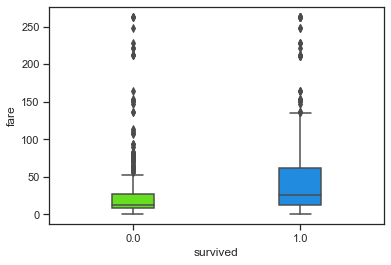

In [12]:
bp=sns.boxplot(x="survived", y="fare", width=0.25, linewidth=1.5, data=df,palette="gist_rainbow")



Above we see boxplots that shows the fare distribution grouped by our target variable (survival). The left boxplot corresponds to people that died and the right one to people that survived. Alternatively, we could plot the distribution of fare according to survival:

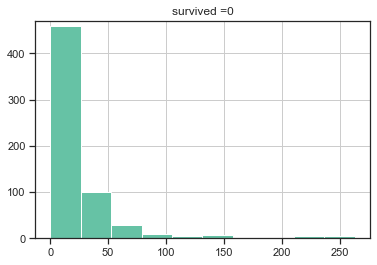

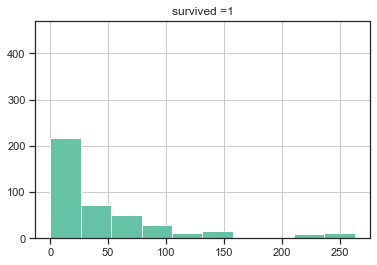

In [13]:
for r in range(2):
    hist = df[df.survived == r].hist('fare')
    plt.title("survived =" + str(r))
    plt.ylim(0,470)
    plt.show()

It seems that people that paid less are less likely to survive. We could use this to predict that people that paid more than 50 will survive. How effective is this threshold? Let's quantify it!

### More EDA

Other observed features may also give us a strong clue about survival.  We could try to get a sense by slicing and plotting the data in a number of ways: 

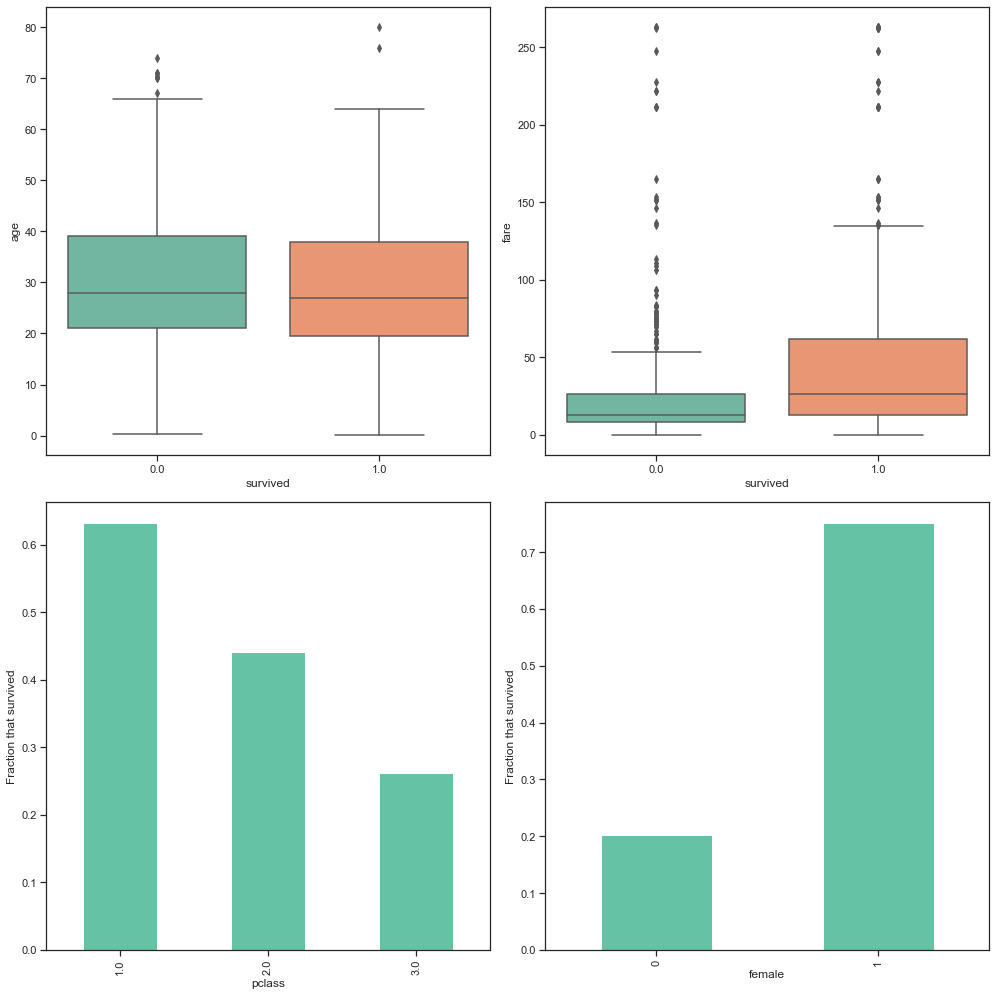

In [14]:
# Names of different columns
categorical_cols = ["pclass", "female"]
continuous_cols = ["age", "fare"]
target_col = "survived"
predictor_cols = categorical_cols + continuous_cols

# This is to plot everything in a 2x2 space
rows, cols = 2, 2
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(7*cols, 7*rows))
axs = axs.flatten()
posn = 0

# Plot continous features
for col in continuous_cols:
    sns.boxplot(x=target_col, y=col, data=df, ax=axs[posn])
    axs[posn].set_ylabel(col)
    axs[posn].set_title("")
    posn += 1

# Plot categorical features
for col in categorical_cols:
    df.groupby(col)[target_col].mean().plot(kind="bar", ax=axs[posn])
    axs[posn].set_ylabel("Fraction that survived")
    posn += 1
    
plt.tight_layout()

Note the graphs, as we've drawn them here, are a little misleading.  If we're not careful, we might conlcude, by looking at the bottom row, that passengers identifying as female, regardless of passenger class, survived at about the same rate as did first class passengers, regardless of gender.  But this is not the case. The reason that we are tempted to conclude this is that the bars are visually similar in height.  However, this only happened because we did not force the y-axes of the two bottom figures to have the same scale.  

Even if we fixed this, it might *still* be misleading.  (Why?)

To get another perspective, we could try to up our visualization game by putting more information into a single plot.  For example, we can combine the information on passenger outcomes by gender *and* fare in a single visualization.  (We will have to do a little extra work to make it look nice...)  

Let's try that in two different ways:

In [15]:
# Prep to do some cosmetic work based on data

surv_labels = ["died","survived"]
gend_labels = ["male","female"]

surv=[]
gend=[]
for i in df.index:
    x=bool2txt(df.loc[i].at["survived"],surv_labels)
    surv.append(x)
    x=bool2txt(df.loc[i].at["female"],gend_labels)
    gend.append(x)

df["surv_txt"] = surv
df["gend_txt"] = gend

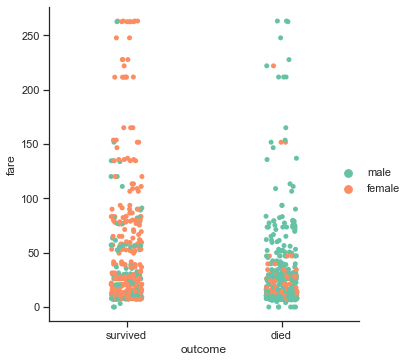

In [16]:
# Plot the data one way...

p1=sns.catplot(x="surv_txt", y="fare", data=df,hue="female")

# Do some more cosmetic work to make plot more cognitively pleasing

p1.set_xlabels("outcome")

for t, l in zip(p1._legend.texts, gend_labels): t.set_text(l)
p1._legend.set_title("")
plt.show()

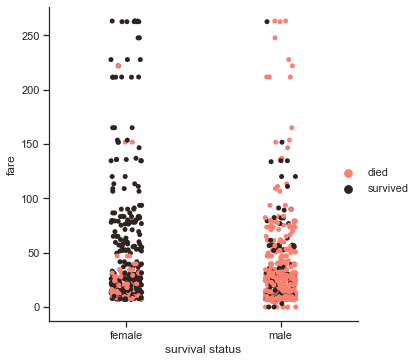

In [17]:
# Plot the data another way...

p2=sns.catplot(x="gend_txt", y="fare", data=df,hue="survived",palette="dark:salmon_r")

# Do some more cosmetic work to make plot more cognitively pleasing

p2.set_xlabels("survival status")

for t, l in zip(p2._legend.texts,surv_labels): t.set_text(l)
p2._legend.set_title("")
plt.show()


# --> It is often the case that packages that make some things really easy require a lot of
#     extra steps if you want to tweak something that is not baked in...

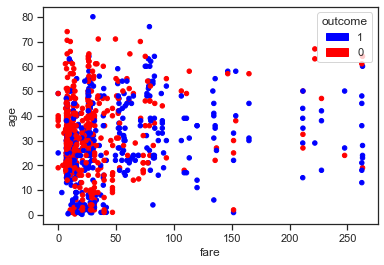

In [18]:
import matplotlib.patches as mpatches

cmap = {1: 'blue', 0: 'red'}
df.plot(kind="scatter", x="fare", y="age", c=[cmap[c] for c in df[target_col]])
plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc=1, title="outcome", frameon=True)
plt.show()

This now begs the question: which features provide the most information? 

### The Logit model: Parametric Probability Estimation

We will start our modeling, as we often do, with "traditional" statistical techniques.  For many problems, conventional statistical or econometric methods are sufficient, or better, than many ML methods, and are often much easier to interpret.

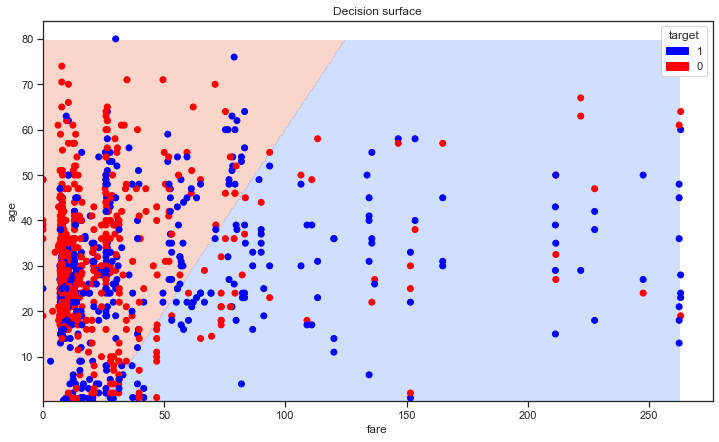

In [19]:
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

logit_model = linear_model.LogisticRegression()
logit_model.fit(X=df[predictor_cols], y=df[target_col])
Decision_Surface(df, "fare", "age", df.survived, logit_model, False)

And now, using `statsmodels`:

In [20]:
# set up the formula.  
#   This is a general code snippet that will always work, even if we don't know the formula
#   In this case, of course, I do know the formua and could just write: survived ~ pclass + female + age + fare
#

my_formula=target_col + ' ~ '
for i in range(len(predictor_cols)):
    if i > 0:
        my_formula = my_formula + " + "       
    my_formula = my_formula+ predictor_cols[i]
print("Formula: ", my_formula)

Formula:  survived ~ pclass + female + age + fare


In [21]:
import statsmodels.formula.api as smf

# We could use this:
#
#   df = sm.add_constant(df, prepend=False)
#   predictor_cols = 'const' + predictor_cols
#   model = sm.Logit(df[target_col], df[predictor_cols])
#   logit_model_sm = model.fit()
#
# But using formulas is easier...

model = smf.logit(my_formula, data = df) 
logit_model_sm = model.fit()
print(logit_model_sm.summary())



Optimization terminated successfully.
         Current function value: 0.469878
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                 1041
Model:                          Logit   Df Residuals:                     1036
Method:                           MLE   Df Model:                            4
Date:                Thu, 08 Jul 2021   Pseudo R-squ.:                  0.3044
Time:                        15:32:06   Log-Likelihood:                -489.14
converged:                       True   LL-Null:                       -703.19
Covariance Type:            nonrobust   LLR p-value:                 2.351e-91
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2563      0.445      5.068      0.000       1.384       3.129
pclass        -1.1830      0.

Note how useful the `statsmodels` output is for gaining insights into the processes that drive the probability of `survival` in the data set.

For example, we can see that all of the variables, except for `fare`, appear to be significant at conventional levels.  

However, the coefficients of a logit are difficult to interpret directly in the same way we interpret the coefficients for a model estimatd useing OLS (because of the non-linear link function).

Fortunately, `statsmodles` also lets us calculate the marginal effects to see the "average" effect of each factor.

In [22]:
mfx = logit_model_sm.get_margeff()
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:               survived
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pclass        -0.1793      0.018     -9.792      0.000      -0.215      -0.143
female         0.3821      0.013     29.066      0.000       0.356       0.408
age           -0.0052      0.001     -5.659      0.000      -0.007      -0.003
fare          -0.0003      0.000     -0.867      0.386      -0.001       0.000


Interesting!  

It looks like on "average,"  a passenger who was `female` would have had a 38% higher chance of survival than one who was `male`. 

How does that overall result compare to how `female` Third Class passengers did releative to `male` Third Class passengers?

In [23]:
pclass_col = 1                      # in which column is the passenger class data located?
is_first_class = {pclass_col: 1}    # map to records of First Class passengers

mfx = logit_model_sm.get_margeff(atexog=is_first_class)
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:               survived
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pclass        -0.2082      0.019    -11.182      0.000      -0.245      -0.172
female         0.4437      0.025     17.870      0.000       0.395       0.492
age           -0.0060      0.001     -6.100      0.000      -0.008      -0.004
fare          -0.0003      0.000     -0.875      0.382      -0.001       0.000


It looks like `female` passengers in First Class did even better.  

In fact, in First Class, `female` passengers were about 6% *more* likely to survive (`0.4437` - `0.3821`).  This may be due to the shortage of lifeboats, which were first allocated to the First Class passengers, forcing many lower class passengers into the icy water.

(How big an effect on survival did `pclass` have for `female` passengers?)


#### Evaluating the results (a little ...)

We also compute accuracy metrics (for either `scikitlearn` models or `statsmodels` models),  in a number of ways.  

For this example, we are going to calculate a very coarse measure of performance: *the percentage of correct classifications*.  Later in the course, we will look at more robust and informative measures of performance.

In [24]:
# Calculate accuracy using of sklearn logit model using sklearn's metrics package

from sklearn import metrics
pd.DataFrame([dict(zip(predictor_cols, logit_model.coef_[1:]))])
pred = logit_model.predict(df[predictor_cols])
pred_bin    = np.where(pred > 0.5, True, False)  # sk.metrics needs discrete valued data
sk_logit_accuracy = metrics.accuracy_score(pred_bin, df[target_col])   

# Calculate accuracy of statsmodels logit model sklearn's metrics package

pred        = logit_model_sm.predict(df)
pred_bin    = np.where(pred > 0.5, True, False)  # sk.metrics needs discrete valued data
sm_logit_skm_accuracy = metrics.accuracy_score(pred_bin, df.survived)

# Calculate accuracy of statsmodels logit model using statsmodels pred.table (confusion matrix)

logit_pred_tab = logit_model_sm.pred_table()
sm_logit_sm_accuracy = cm2accuracy(logit_pred_tab)



print("Confusion Matrix")

print(pd.DataFrame(logit_pred_tab))
print()

# Compare results

print ("Accuracy (sk logit) fr SKM = %.2f" % sk_logit_accuracy)
print ("Accuracy (sm logit) fr CM  = %.2f" % sm_logit_skm_accuracy)
print ("Accuracy (sm logit) fr SKM = %.2f" % sm_logit_skm_accuracy)



Confusion Matrix
       0      1
0  525.0   93.0
1  125.0  298.0

Accuracy (sk logit) fr SKM = 0.79
Accuracy (sm logit) fr CM  = 0.79
Accuracy (sm logit) fr SKM = 0.79


### The Classifier Tree: Recursive Splitting

Another way to predict the outcomomes for Titanic passengers is to use recursive partitioning (RP) algorithms.   


#### Formalizing some of the intuition from EDA

***


**Entropy** ($H$) and **information gain** ($IG$) are useful tools for measuring the effectiveness of a split on the data. Entropy measures how random data is, information gain is a measure of the reduction in randomness after performing a split.

<table style="border: 0px">
<tr style="border: 0px">
<td style="border: 0px"><img src="https://github.com/bwolfson2/foster_2020/blob/master/Module2_Supervised/images/dsfb_0304.png?raw=1" height=80% width=80%>
Figure 3-4. Splitting the "write-off" sample into two segments, based on splitting the Balance attribute (account balance) at 50K.</td>
<td style="border: 0px; width: 30px"></td>
<td style="border: 0px"><img src="https://github.com/bwolfson2/foster_2020/blob/master/Module2_Supervised/images/dsfb_0305.png?raw=1" height=75% width=75%>
Figure 3-5. A classification tree split on the three-values Residence attribute.</td>
</tr>
</table>

Given the data, it is fairly straight forward to calculate both of these quantities.

#### Getting started with entropy and information gain

At the top of the notebook we defined Python functions for calculating these information theoretic measures of homogeneity (the *entropy*, $H$, and the *information gain*, $IG$).

We can now use these to test our prior hunch, that using 50 as a split on a passenger's `fare` allows us to predict whether someone will survive.  

In [25]:
threshold = 50
prior_entropy = entropy(df["survived"])
IG = information_gain(df, "fare", "survived", threshold)
print ("IG of %.4f using a threshold of %.2f given a prior entropy of %.4f" % (IG, threshold, prior_entropy))

IG of 0.0554 using a threshold of 50.00 given a prior entropy of 0.9745


But is `50` the *best* choice possible for a splitting critierion?  

We can answer that question definitively, with the helpf of a few lines of code, by applying brute-force search and simply testing *every* possible split for `fare`.

In [26]:
def best_threshold(df, info_column, target_column, criteria=information_gain):
    maximum_ig = 0

    for thresh in df[info_column]:
        IG = criteria(df, info_column, target_column, thresh)
        if IG > maximum_ig:
            maximum_ig = IG
            maximum_threshold = thresh
            
    return (maximum_threshold, maximum_ig)

In [27]:
maximum_threshold, maximum_ig = best_threshold(df, "fare", "survived")

print ("The maximum IG we can achieve splitting on `fare` is %.4f using a split threshold of %.2f" % (maximum_ig, maximum_threshold))

The maximum IG we can achieve splitting on `fare` is 0.0578 using a split threshold of 52.00


In the same way that we automated the search for the best threshold, we can write a function to search through *every* variable of interest and find it's best splitting threshold.  From the results of that search, we can identify the variable whose best splitting threshold produces the most informaiton gain!

Now that we have a way of calculating $H$ and $IG$, let's test our prior hunch, that using 50 as a split on fare allows us to determine if someone will survive.

How good was our guess of 50? Let's use a function to loop through all possible splits on fare and see what is the best!

In [28]:
def best_threshold(df, info_column, target_column, criteria=information_gain):
    maximum_ig = 0


    for thresh in df[info_column]:
        IG = criteria(df, info_column, target_column, thresh)
        if IG > maximum_ig:
            maximum_ig = IG
            maximum_threshold = thresh
            
    return (maximum_threshold, maximum_ig)

In [29]:
maximum_threshold, maximum_ig = best_threshold(df, "fare", "survived")

print ("the maximum IG we can achieve splitting on `fare` is %.4f using a split threshold of %.2f" % (maximum_ig, maximum_threshold))

the maximum IG we can achieve splitting on `fare` is 0.0578 using a split threshold of 52.00


#### Finding the *best* split across *all* predictors

During our EDA, we noticed, that a split of about `50` on `fare` seemed to provide good discrimination between passenger outcomes.  It turned out that we were pretty close.

But how do we know that the best split on `fare` is the best split possible for the data set?  There could be other variables that provide even more information, if we split them properly.

We can answer this question in the same way we answered the previous one.  Another short routine can apply brute force to searching across *all* predictors and finding the best split on each and then selecting the one that provides the most information.

In [30]:
def best_split(df, info_columns, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0
    maximum_column = ""
    
    for info_column in info_columns:
        thresh, ig = best_threshold(df, info_column, target_column, criteria)
        
        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = thresh
            maximum_column = info_column

    return maximum_column, maximum_threshold, maximum_ig

In [31]:
max_col, max_threshold, max_ig = best_split(df, predictor_cols, "survived")

print ("The best column to split on is %s giving us a IG of %.4f using a thresh of %.2f" % (max_col, max_ig, max_threshold))

The best column to split on is female giving us a IG of 0.2164 using a thresh of 0.00


Of course, splitting the data one time sometimes isn't enough to make accurate categorical predictions. However, we can continue to split the data recursively, building a tree-structured model that may give better results. This recursive splitting is the basis for a "decision tree classifier" or "classifier tree", a popular and powerful class of machine learning algorithm. In particular, this specific algorithm is known as ID3 for Iterative Dichotomizer. 

What are some other ways you might consider splitting the data?

### Scaling up the splitting using `sklearn`

Rather than build a classifier tree from scratch (you could now do this!) let's use the implementation in `sklearn` implementation which includes some additional functionality. 

In [32]:
from sklearn.tree import DecisionTreeClassifier
# Let's define the model (tree)
decision_tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")   # Look at those 2 arguments !!! 
# Let's tell the model what is the data
decision_tree.fit(df[predictor_cols], df[target_col])

DecisionTreeClassifier(criterion='entropy', max_depth=3)

We now have a classifier tree, let's visualize the results!

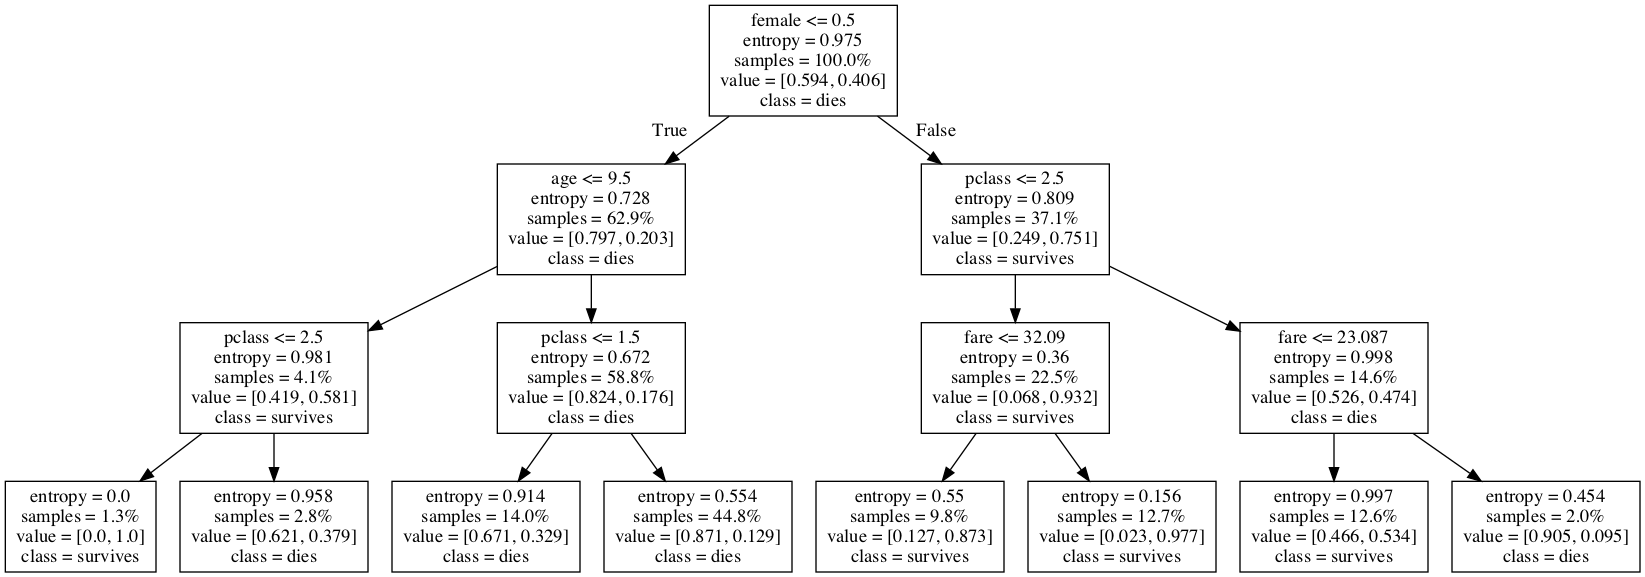

In [33]:
from IPython.display import Image
from sklearn.tree import export_graphviz

visualize_tree(decision_tree, predictor_cols, ["dies", "survives"])

### Evaluating the results (a little more...)

Let's look at `"age"` and `"fare"`, including the **DECISION SURFACE!!**

More details for this graph: [sklearn decision surface](https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py)

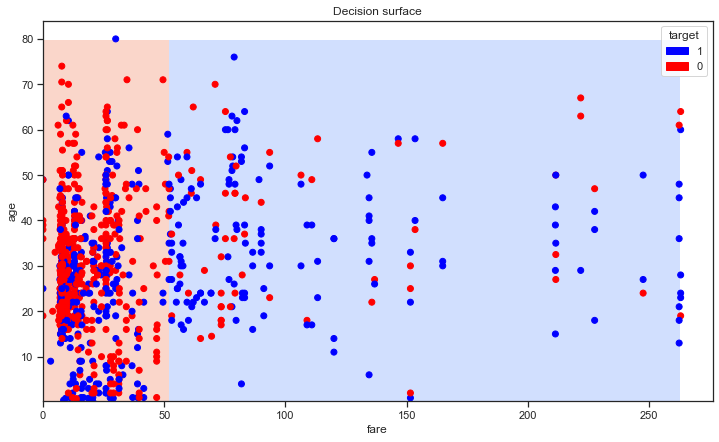

In [34]:
tree_depth=1

model = DecisionTreeClassifier(max_depth=tree_depth, criterion="entropy")
Decision_Surface(df, "fare", "age", df.survived, model)

In [35]:
df.iloc[:,[2,3]].head()

,age,fare
0,29.0000,211.3375
1,0.9167,151.5500
2,2.0000,151.5500
3,30.0000,151.5500
4,25.0000,151.5500


How good is our model? Let's compute accuracy, the percent of times where we correctly identified whether a passenger survives.

In [36]:
from sklearn import metrics
print ( "Accuracy = %.2f" % (metrics.accuracy_score(decision_tree.predict(df[predictor_cols]), df["survived"])) )

Accuracy = 0.81
